# Aeiral Cactus Identification

## Introduction

This notebook tackles the Aerial Cactus Identification challenge on Kaggle, where the task is to build a binary classifier that can identify whether an aerial image of arid land contains a cactus. The images are 32×32 pixels, and the objective is to predict the presence of cacti with high accuracy. 

While this is a image classification task focused on identifying cacti, it has broader relevance for ecosystem monitoring and land management. The ability to automatically detect vegetation aerial imagery can support important applications in forestry, invasive species control, agricultural land use, and environmental conservation. These methods can enable large-scale assessments of ecosystem health and land coverchange.

We’ll use a Convolutional Neural Network (CNN) trained on the provided labeled dataset and evaluate the model on a validation set. The final model will be used to generate predictions for the test set.

## Setup 
### Import Libraries

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aerial-cactus-identification/sample_submission.csv
/kaggle/input/aerial-cactus-identification/train.zip
/kaggle/input/aerial-cactus-identification/test.zip
/kaggle/input/aerial-cactus-identification/train.csv


In [64]:
from zipfile import ZipFile

import matplotlib.pyplot as plt

from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import keras
from keras import layers
from keras import initializers

from sklearn.model_selection import train_test_split
import tensorflow_io as tfio

from sklearn.utils import class_weight

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
    confusion_matrix,ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score,
    f1_score,)

### Import Data

In [23]:
train_df = pd.read_csv('/kaggle/input/aerial-cactus-identification/train.csv')

In [24]:
zip_path = "/kaggle/input/aerial-cactus-identification/train.zip"

In [25]:
from zipfile import ZipFile
from PIL import Image
import numpy as np

# Open zip file and read images into memory
image_dir_in_zip = "train/"

image_arrays = []
image_labels = []

with ZipFile(zip_path, 'r') as archive:
    for i, row in train_df.iterrows():
        file_path = image_dir_in_zip + row['id']
        label = row['has_cactus']

        with archive.open(file_path) as file:
            img = Image.open(file).convert('RGB')
            img = img.resize((32, 32))  # Resize for cactus dataset
            arr = np.array(img).astype(np.float32) / 255.0  # Normalize
            image_arrays.append(arr)
            image_labels.append(label)

# Convert to numpy arrays
X = np.stack(image_arrays)
y = np.array(image_labels, dtype=np.float32)

## Exploratory Data Analysis

Before training our models, we will explore the dataset to understand its structure. The training dataset is labeled with a binary value, with
`has_cactus = 1` meaning that the image contains a cactus, while `has_cactus = 0` means there is no cactus in the image.
The images are low resolution (32×32 pixels), so careful preprocessing and architecture tuning is key.



In [28]:
train_df.shape

(17500, 2)

In [29]:
X.shape

(17500, 32, 32, 3)

In [32]:
y.shape

(17500,)

In [8]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [9]:
train_df.describe()

,has_cactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


Look like roughly 75% of our images have a cactus in them. We'll use stratify later to ensure `has_cactus` is proportional in the training and testing sets. A future iteration of this notebook could look at a balanced dataset to see if that improves performance.

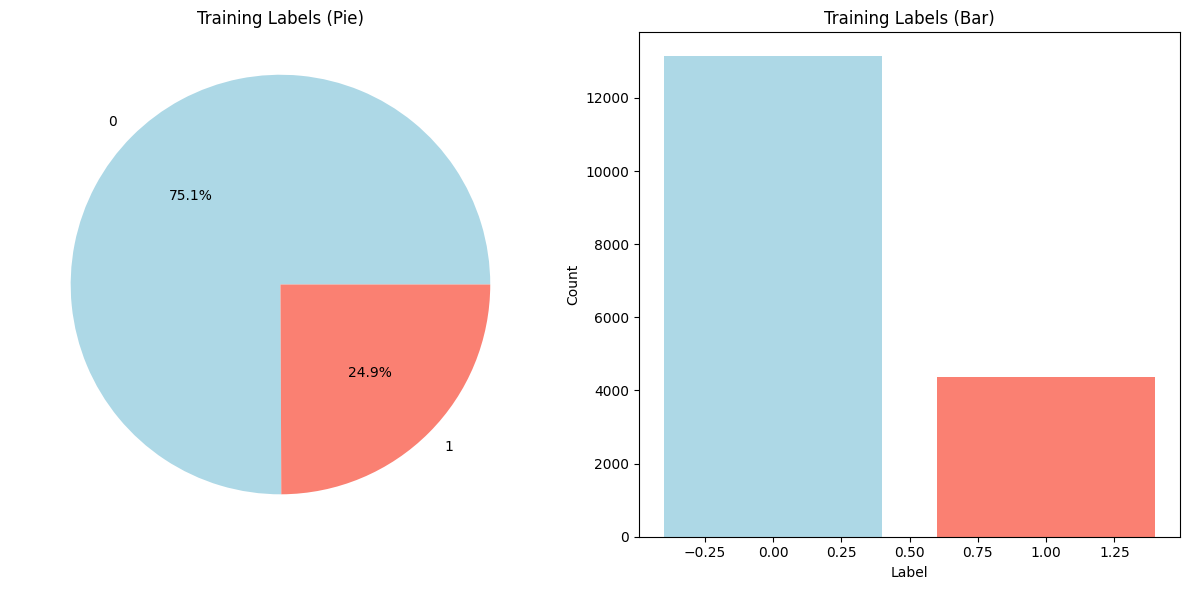

In [10]:
# Compute label counts
has_cactus_counts = train_df['has_cactus'].value_counts()
cactus_label = sorted(has_cactus_counts.index)
counts = has_cactus_counts.values

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
axes[0].pie(counts, labels=cactus_label, colors=['lightblue','salmon'], autopct='%1.1f%%')
axes[0].axis('equal')
axes[0].set_title('Training Labels (Pie)')

# Bar chart
axes[1].bar(cactus_label, counts, color=['lightblue','salmon'])
axes[1].set_title('Training Labels (Bar)')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

We'll also take a look at a few sample images that we're dealing with.

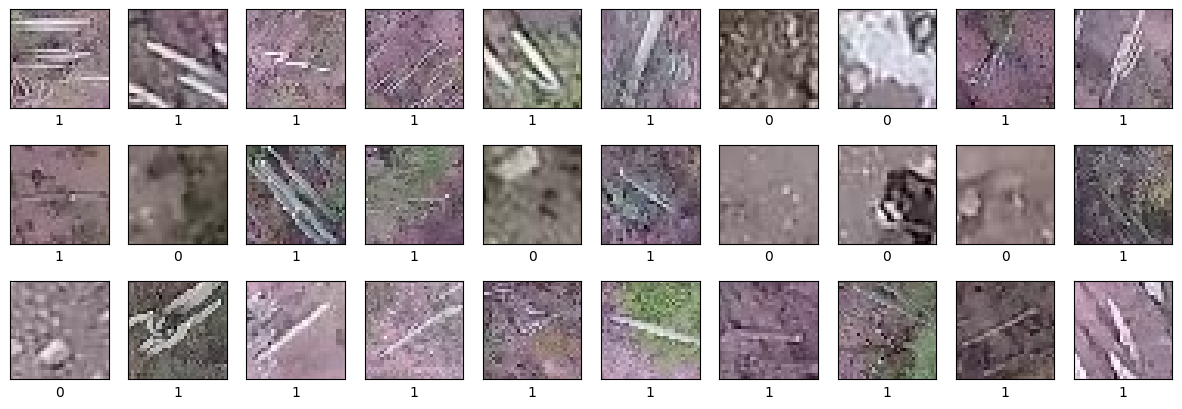

In [11]:
# Open the zip file
with ZipFile(zip_path, 'r') as archive:
    fig, ax = plt.subplots(3, 10, figsize=(15, 5))
    for i, axis in enumerate(ax.flat):
        # Get image ID and label
        image_id = train_df.id[i]
        label = train_df.has_cactus[i]
        
        # Read the image bytes from zip and open as PIL image
        with archive.open(f'train/{image_id}') as file:
            image = Image.open(file).convert('RGB')
            axis.imshow(image)
            axis.set(xticks=[], yticks=[], xlabel=label)

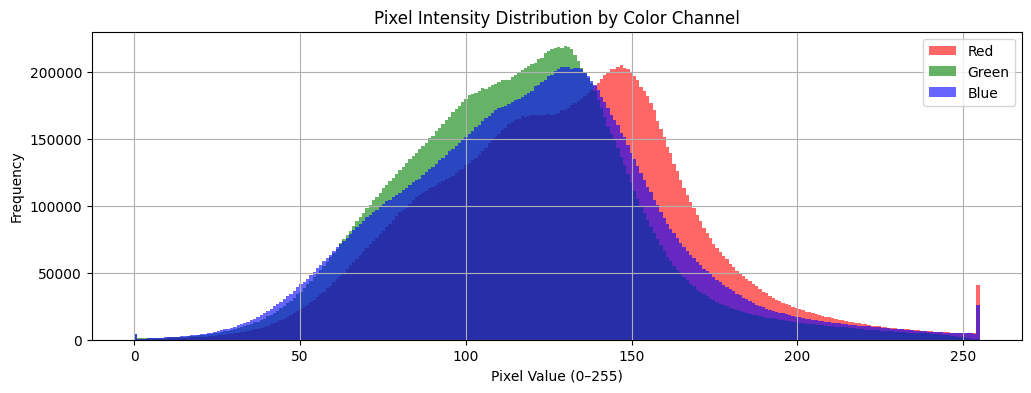

In [12]:
red_vals, green_vals, blue_vals = [], [], []

with ZipFile(zip_path, 'r') as archive:
    for image_id in train_df['id']:
        with archive.open(f'train/{image_id}') as file:
            image = Image.open(file).convert('RGB')
            arr = np.array(image)

            red_vals.extend(arr[:, :, 0].flatten())
            green_vals.extend(arr[:, :, 1].flatten())
            blue_vals.extend(arr[:, :, 2].flatten())

# Plot the histograms
plt.figure(figsize=(12, 4))
plt.hist(red_vals, bins=256, color='red', alpha=0.6, label='Red')
plt.hist(green_vals, bins=256, color='green', alpha=0.6, label='Green')
plt.hist(blue_vals, bins=256, color='blue', alpha=0.6, label='Blue')
plt.title('Pixel Intensity Distribution by Color Channel')
plt.xlabel('Pixel Value (0–255)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## Modeling

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.2, 
                                                  stratify=y, 
                                                  random_state=42)

In [18]:
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # For JPGs
    image = tf.image.resize(image, [32, 32])         # Cactus images are 32x32
    image = tf.cast(image, tf.float32) / 255.0       # Normalize to [0, 1]
    return image, label

In [34]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [36]:
 model_1 = keras.Sequential([
    
    layers.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),

    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')

])
model_1.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='binary_crossentropy', 
                metrics=['accuracy', 'auc'])
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, 
                           restore_best_weights=True)

hist_1 = model_1.fit(train_ds, 
                     validation_data=val_ds, 
                     epochs=50, 
                     callbacks=[early_stop])

Epoch 1/50


I0000 00:00:1753731202.949051     103 service.cc:148] XLA service 0x7b9328007e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753731202.955407     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753731202.955428     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753731203.637166     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


 56/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7517 - auc: 0.5036 - loss: 0.6895

I0000 00:00:1753731207.825877     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7537 - auc: 0.5025 - loss: 0.6269 - val_accuracy: 0.7506 - val_auc: 0.5493 - val_loss: 0.5621
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7532 - auc: 0.5021 - loss: 0.5606 - val_accuracy: 0.7506 - val_auc: 0.5221 - val_loss: 0.5614
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7548 - auc: 0.4902 - loss: 0.5598 - val_accuracy: 0.7506 - val_auc: 0.5326 - val_loss: 0.5608
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7520 - auc: 0.5135 - loss: 0.5609 - val_accuracy: 0.7506 - val_auc: 0.6762 - val_loss: 0.5609
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7538 - auc: 0.5034 - loss: 0.5597 - val_accuracy: 0.7506 - val_auc: 0.6810 - val_loss: 0.5601
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7534 - auc: 0.5187 - loss: 0.5586 - val_accuracy: 0.7506 - val_auc: 0.8520 - val_loss: 0.5596
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/st

In [49]:
model_2 = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    
    layers.Conv2D(32, (3,3), activation='relu', padding = 'same'),
    layers.Conv2D(32, (3,3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
    layers.Conv2D(64, (3,3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu', padding = 'same'),
    layers.Conv2D(128, (3,3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_2.compile(optimizer=Adam(learning_rate=0.001), 
                loss='binary_crossentropy', 
                metrics=['accuracy', 'auc'])

model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,409 (2.10 MB)

 Trainable params: 549,409 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
hist_2 = model_2.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7467 - auc: 0.4938 - loss: 0.5754 - val_accuracy: 0.7506 - val_auc: 0.5000 - val_loss: 0.5618
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7542 - auc: 0.4963 - loss: 0.5618 - val_accuracy: 0.7506 - val_auc: 0.5000 - val_loss: 0.5641
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7541 - auc: 0.4967 - loss: 0.5611 - val_accuracy: 0.7506 - val_auc: 0.5000 - val_loss: 0.5643
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7530 - auc: 0.4982 - loss: 0.5614 - val_accuracy: 0.7506 - val_auc: 0.5000 - val_loss: 0.5624
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7522 - auc: 0.4977 - loss: 0.5624 - val_accuracy: 0.7506 - val_auc: 0.5000 - val_loss: 0.5617
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7562 - auc: 0.4952 - loss: 0.5576 - val_accuracy: 0.7506 - val_auc: 0.5000 - val_loss: 0.5619
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━

In [51]:
model_3 = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3,3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3,3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3,3), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
model_3.compile(optimizer=Adam(learning_rate=0.001), 
                loss='binary_crossentropy', 
                metrics=['accuracy', 'auc'])
model_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 128)      │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 128)      │             

 Total params: 550,753 (2.10 MB)

 Trainable params: 549,857 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [52]:
hist_3 = model_3.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9216 - auc: 0.9466 - loss: 0.2577 - val_accuracy: 0.2494 - val_auc: 0.5000 - val_loss: 6.0145
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9787 - auc: 0.9955 - loss: 0.0641 - val_accuracy: 0.9420 - val_auc: 0.9963 - val_loss: 0.1573
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9874 - auc: 0.9979 - loss: 0.0415 - val_accuracy: 0.9457 - val_auc: 0.9876 - val_loss: 0.1517
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9901 - auc: 0.9982 - loss: 0.0339 - val_accuracy: 0.9760 - val_auc: 0.9928 - val_loss: 0.0829
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9882 - auc: 0.9987 - loss: 0.0343 - val_accuracy: 0.9886 - val_auc: 0.9980 - val_loss: 0.0358
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9918 - auc: 0.9986 - loss: 0.0300 - val_accuracy: 0.9151 - val_auc: 0.9825 - val_loss: 0.2550
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━

## Analysis

In [42]:
def plot_training_history(history, model=""):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Loss
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title(f'{model} Loss over Epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Accuracy
    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title(f'{model} Accuracy over Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # AUC
    axs[2].plot(history.history['auc'], label='Training AUC')
    axs[2].plot(history.history['val_auc'], label='Validation AUC')
    axs[2].set_title(f'{model} AUC over Epochs')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('AUC')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

In [84]:
def plot_confusion_matrix_and_metrics(model, 
                                      dataset, 
                                      threshold=0.5, 
                                      class_names=["No Cactus", "Has Cactus"], 
                                      title=None):
    # Gather true labels
    true_labels = []
    for _, labels in dataset:
        true_labels.extend(labels.numpy())
    true_labels = np.array(true_labels)

    # Predict probabilities
    pred_probs = model.predict(dataset).flatten()
    pred_labels = (pred_probs > threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    ax.set_title(title or f"Confusion Matrix (Threshold = {threshold})")
    plt.show()

    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, zero_division=0)
    recall = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [82]:
def evaluate_model(y_true, y_pred_probs, threshold=0.5, title='Confusion Matrix'):
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Cactus", "Has Cactus"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

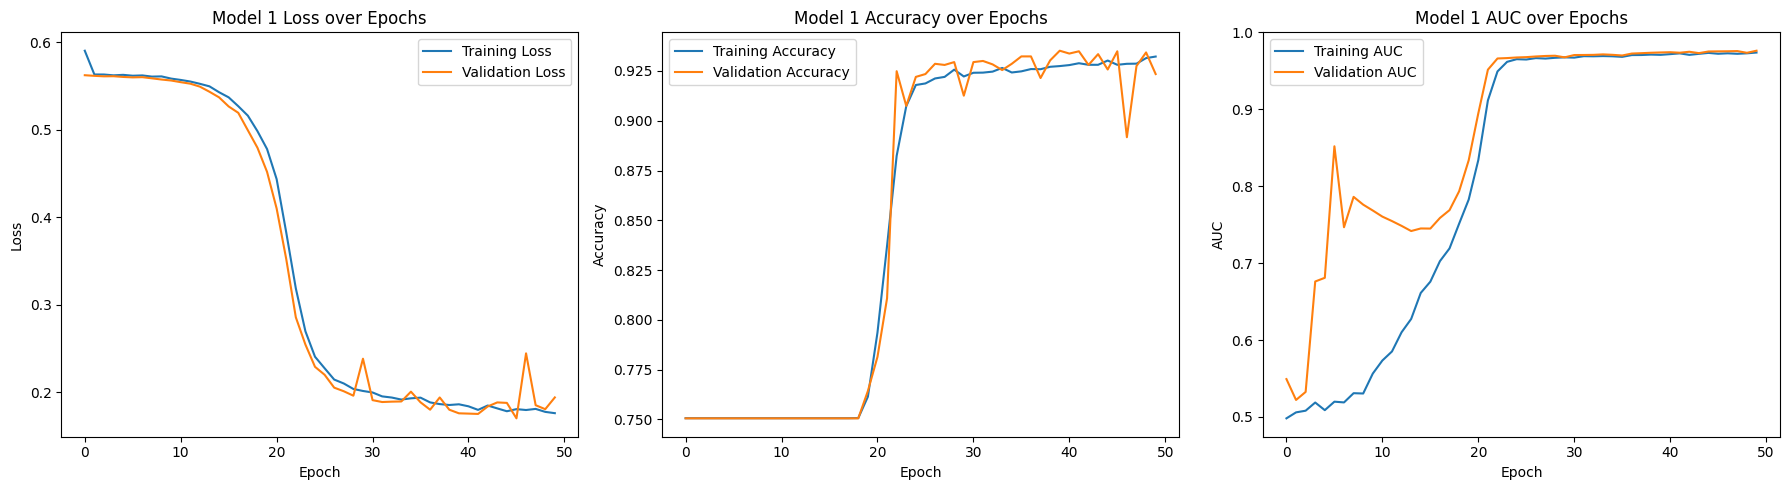

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


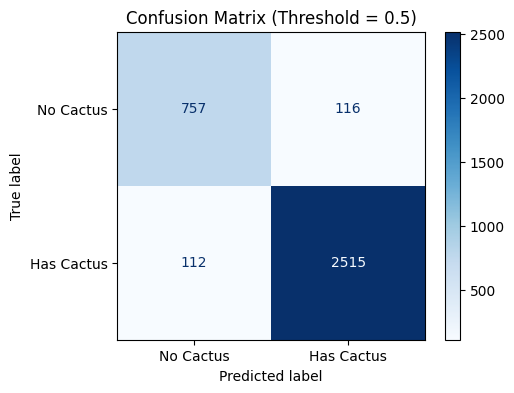

In [91]:
model_metrics = []
plot_training_history(hist_1, "Model 1")
model_1_metrics = plot_confusion_matrix_and_metrics(model_1, val_ds)
print(model_1_metrics)
model_1_metrics["model"] = "model_1"
model_metrics.append(model_1_metrics)

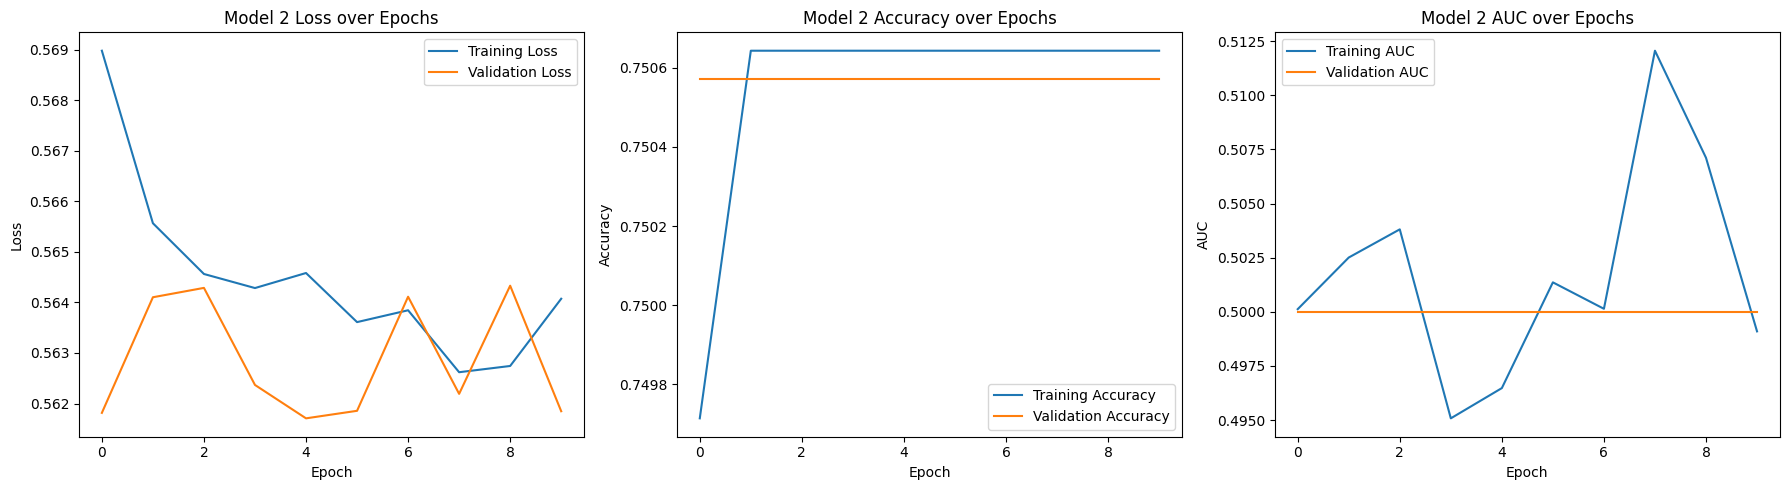

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


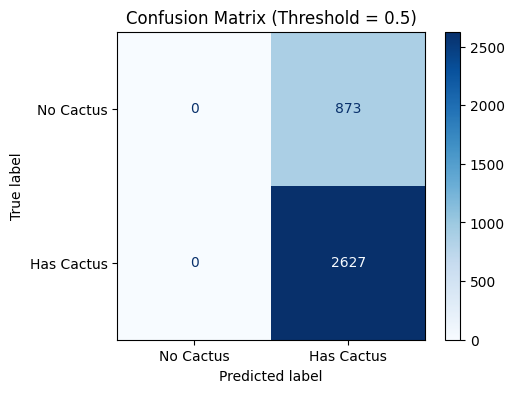

In [92]:
plot_training_history(hist_2, "Model 2")
model_2_metrics = plot_confusion_matrix_and_metrics(model_2, val_ds)
print(model_2_metrics)
model_2_metrics["model"] = "model_2"
model_metrics.append(model_2_metrics)

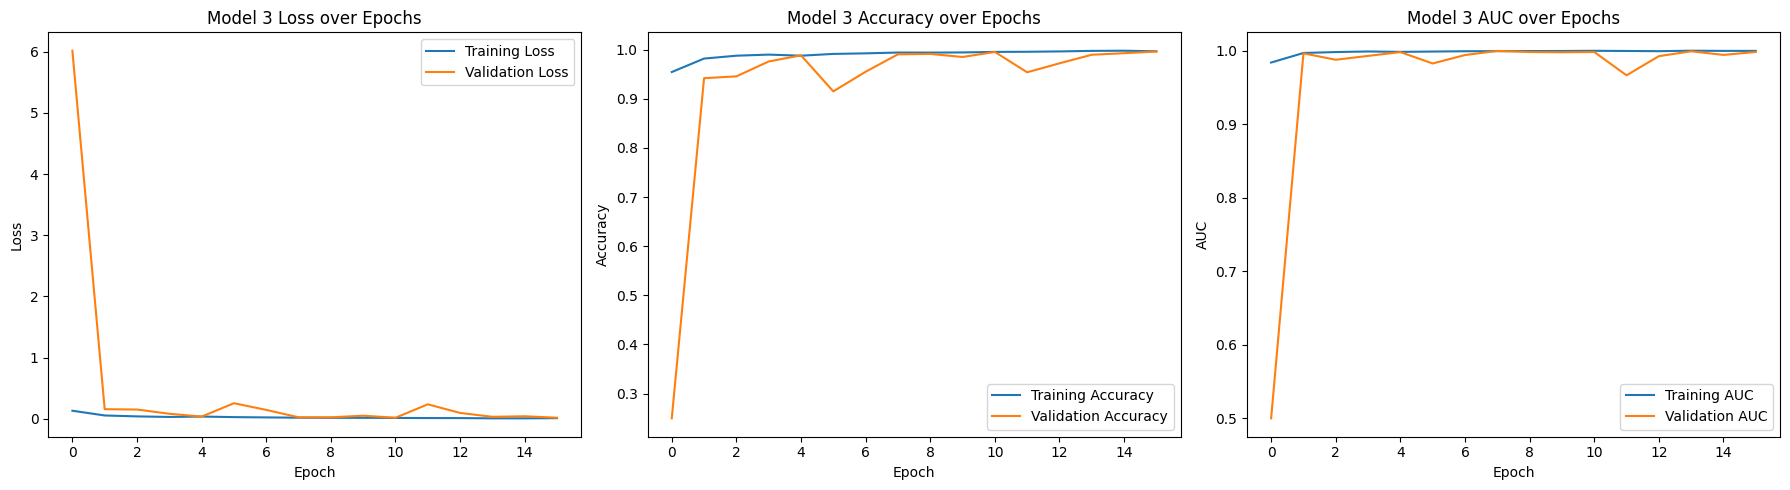

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


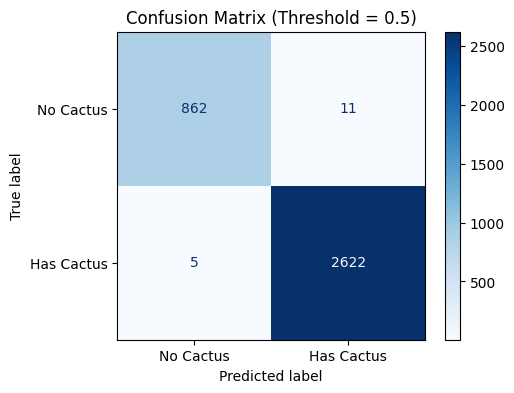

{'accuracy': 0.9954285714285714, 'precision': 0.9958222559817699, 'recall': 0.9980966882375333, 'f1_score': 0.996958174904943}


In [93]:
plot_training_history(hist_3, "Model 3")
model_3_metrics = plot_confusion_matrix_and_metrics(model_3, val_ds)
print(model_3_metrics)
model_3_metrics["model"] = "model_3"
model_metrics.append(model_3_metrics)

In [95]:
df_metrics = pd.DataFrame(model_metrics)
df_metrics.set_index("model", inplace=True)
df_metrics

,accuracy,precision,recall,f1_score
model,,,,
model_1,0.934857,0.955910,0.957366,0.956638
model_2,0.750571,0.750571,1.000000,0.857516
model_3,0.995429,0.995822,0.998097,0.996958


Based on the above 3 models, looks like model 3 is our best performing model, followed by model 1. Model 2 ran into some strange behavior as it predicted that everything was a cactus. While it may appear to be more poowerful than model 1 due to its complexity, the lack of batch normalizatioon and dropout between convolution layers can lead to issues like overfitting and poor generalization on the validation data. 

### Kaggle Competition Performance

In [98]:
test_zip_path = "/kaggle/input/aerial-cactus-identification/test.zip"

with ZipFile(test_zip_path, 'r') as archive:
    test_ids = [name.split('/')[-1] for name in archive.namelist() if name.startswith("test/") and name.endswith(".jpg")]
    images = []

    for image_id in test_ids:
        with archive.open(f"test/{image_id}") as file:
            img = Image.open(file).convert("RGB").resize((32, 32))
            img = tf.keras.utils.img_to_array(img) / 255.0
            images.append(img)

images = np.array(images, dtype=np.float32)
submit_ds = tf.data.Dataset.from_tensor_slices(images).batch(32).prefetch(tf.data.AUTOTUNE)

In [99]:
#results = model_1.predict(submit_ds).flatten()
#results = model_2.predict(submit_ds).flatten()
results = model_3.predict(submit_ds).flatten()

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [100]:
submission = pd.DataFrame({
    'id': test_ids,
    'has_cactus': results
})
submission.to_csv("submission.csv", index=False)

In [101]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.987503
1,001ee6d8564003107853118ab87df407.jpg,0.044438
2,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.975461
3,0059dfa41de4441fc23b9a4b98ba99cb.jpg,0.985451
4,008d9fce71c8e03a4c9cdd15ea908573.jpg,0.044780


|Model Number | Kaggle Competition Score (Area ROC)|
|------------|-----------|
|Model 1|0.9526|
|Model 2|0.5000|
|Model 3|0.9979|

The Kaggle competition scores the models using by calculating the area under the ROC curve. As seen above, models 1 and 3 performed very well.

## Conclusion
Our convolutional neural network performed very well in identifying catci from aerial images, as seen in our results in both accuracy and AUC. Models 1 and 3 were able to effectively distinguish cactus from non-cactus images with minimal preprocessing and relatively simple architectures. This show that CNNs are a good fit for tasks involving natural image classification at small scales. I would be interested to see how we can apply this to similar situations. One example could be identifying from aerial images the presense of trees affected by the pine beetle. These are often hard to see from above, but if you can it could be a way to monitor the spread. 

## References
* https://www.tensorflow.org/io
* https://keras.io/api/layers/pooling_layers/max_pooling2d/
* https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
* https://keras.io/api/layers/convolution_layers/convolution2d/
* https://keras.io/api/layers/normalization_layers/batch_normalization/
* https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f
* https://www.geeksforgeeks.org/machine-learning/imreadmulti-in-python-opencv/